In [2]:
import matplotlib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # default library for making plots
import seaborn as sns ; sns.set()# for making prettier plots!
import datetime
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [24, 12]



ModuleNotFoundError: No module named 'matplotlib'

In [3]:
filename = '../HealthDatasets/sample_dataset.csv'

data = pd.read_csv(filename, converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)

columns_dropped = ['Unnamed: 0', 'Is Weekday', 'Elevation (Ft)', 'Day of Week', 'Floors', 
                   'Minutes Lightly Active', 'Minutes Lightly Active', 'Minutes Fairly Active', 
                   'Minutes Very Active', 'Activity Calories', 'Active Score', 'Cardio minutes','Fat Burn calories', 
                   'Deep sleep count', 'Minutes Light sleep', 'Light sleep count', 'REM sleep count', 
                   'Fat Burn minutes', 'Sleep Start time', 'Sleep End time','Time in bed', 'Minutes to fall asleep',
                  'Minutes Awake count', 'Minutes Deep sleep', 'Peak minutes', 'Cardio calories', 'Peak calories',
                  'Normal Cardio calories','Normal Cardio minutes', 'Date', 'Is Weekend']

data_small = data.drop(columns_dropped, axis = 1)

data_dropped_columns = list(data_small.columns.values)

data.drop('Unnamed: 0', axis=1, inplace=True)

data.head(5)

,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,...,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,...,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,...,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,...,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,...,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0
2018-06-28,2018-06-28,4,True,False,1701,1682,559,0.36,18.29,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#data.to_csv('ExampleTable.csv')

In [5]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]



In [6]:
dayGroupedData = data.groupby(['Day of Week']).mean()
dayTypeGroupedData = data.groupby(['Is Weekday']).mean()

dayTypeGroupedData

,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,...,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,
False,6.515152,1.0,2679.545455,1667.606061,8789.909091,5.716061,33.527879,61.666667,11.000000,943.090909,...,28.850000,17.750000,51.750000,19.750000,0.272727,16.452381,7.333333,10.750000,37.500000,157.200000
True,2.963855,0.0,2742.457831,1610.048193,8127.807229,5.378795,23.098916,61.121622,7.578313,788.963855,...,30.892857,17.678571,52.428571,18.964286,0.457831,20.931034,6.456140,10.928571,36.642857,152.803571


In [29]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=False, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

In [30]:
data_cols = list(data.columns.values)
data_cols

['Date',
 'Day of Week',
 'Is Weekday',
 'Is Weekend',
 'Calories Burned',
 'Calories BMR',
 'Steps',
 'Distance (Km)',
 'Elevation (Ft)',
 'Resting Heart Rate',
 'Floors',
 'Minutes Sedentary',
 'Minutes Lightly Active',
 'Minutes Fairly Active',
 'Minutes Very Active',
 'Activity Calories',
 'Active Score',
 'Cardio minutes',
 'Cardio calories',
 'Fat Burn minutes',
 'Fat Burn calories',
 'Peak minutes',
 'Peak calories',
 'Normal Cardio calories',
 'Normal Cardio minutes',
 'Sleep Efficiency',
 'Minutes Asleep',
 'Minutes to fall asleep',
 'Sleep Start time',
 'Sleep End time',
 'Time in bed',
 'Minutes Deep sleep',
 'Deep sleep count',
 'Minutes Light sleep',
 'Light sleep count',
 'Minutes REM sleep',
 'REM sleep count',
 'Minutes Awake',
 'Minutes Awake count',
 '% Deep sleep',
 '% Light sleep',
 '% REM sleep',
 'Day Label',
 'Active exercise',
 'Sleep Bucket',
 'Awake Bucket',
 '% Awake',
 '% Restorative sleep',
 'Restorative sleep mins']

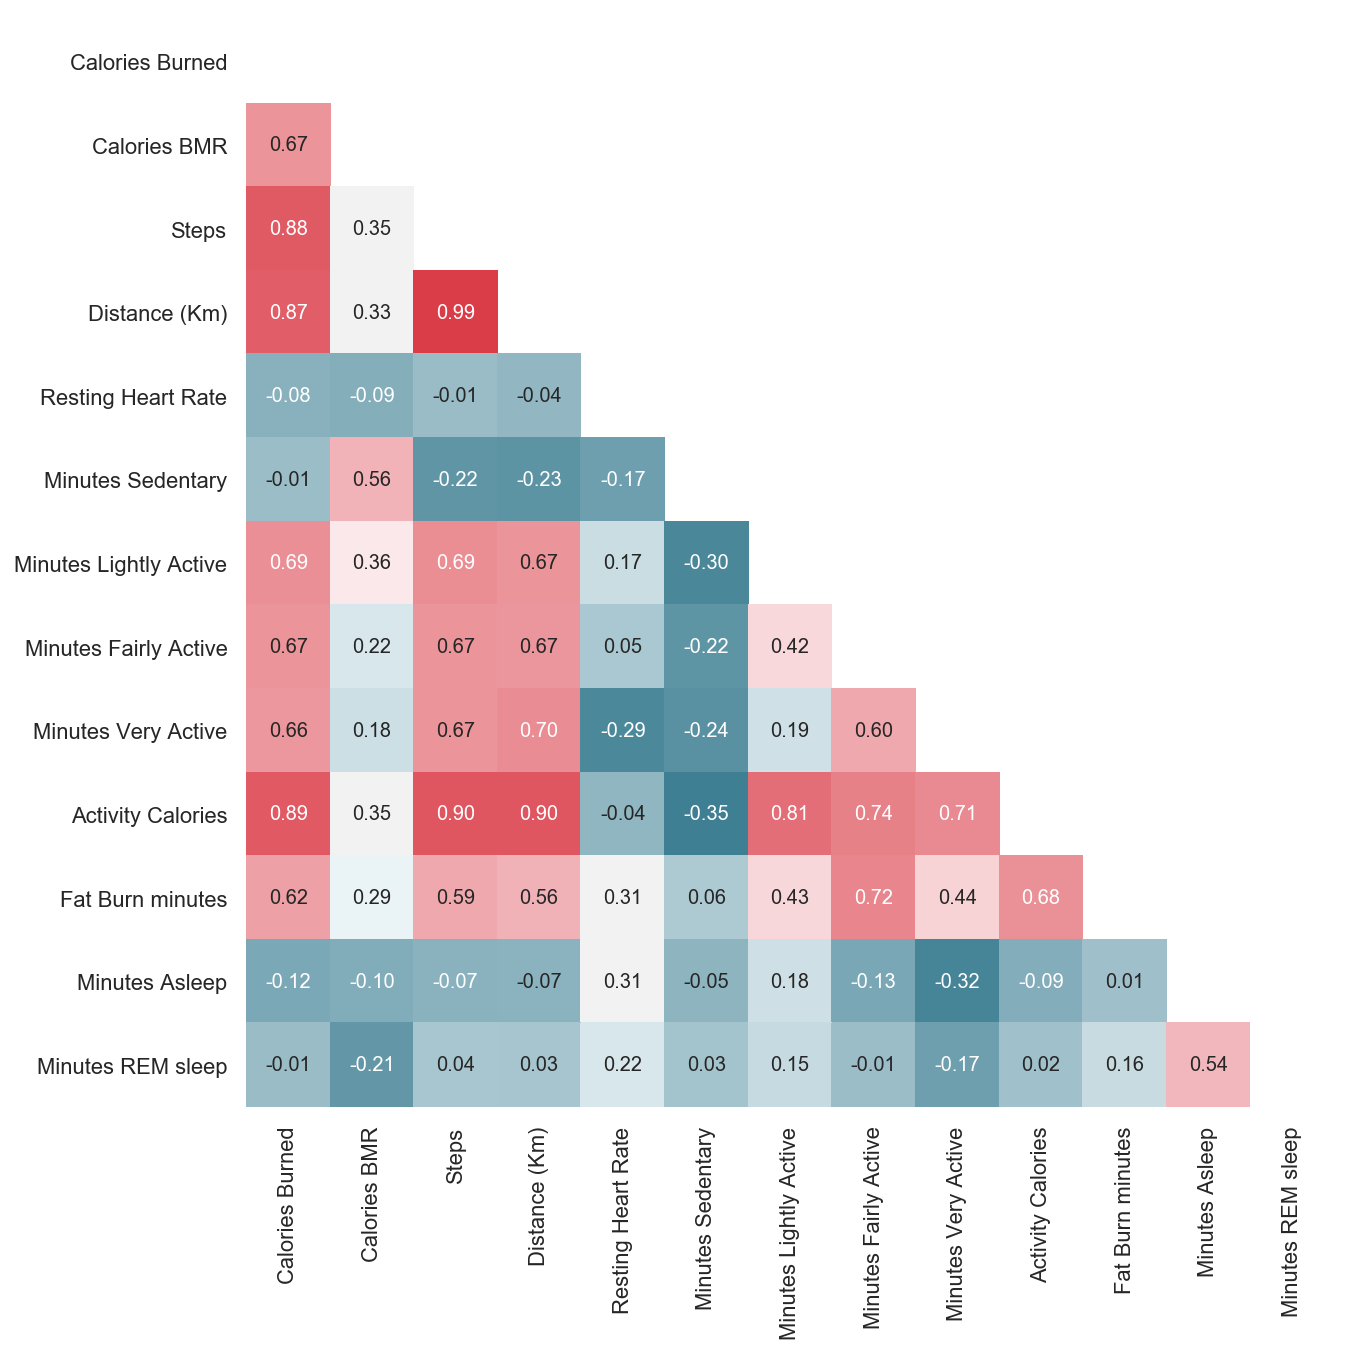

In [31]:
correlationOf = 'Calories Burned'
data_cut = data[[
 'Calories Burned',
 'Calories BMR',
 'Steps',
 'Distance (Km)',
 'Resting Heart Rate',
 'Minutes Sedentary',
 'Minutes Lightly Active',
 'Minutes Fairly Active',
 'Minutes Very Active',
 'Activity Calories',
 'Fat Burn minutes',
 'Minutes Asleep',
 'Minutes REM sleep']]
plot_heatmap(data_cut.corr(), correlationOf, '')

/Users/justinlarocque-villiers/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/justinlarocque-villiers/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


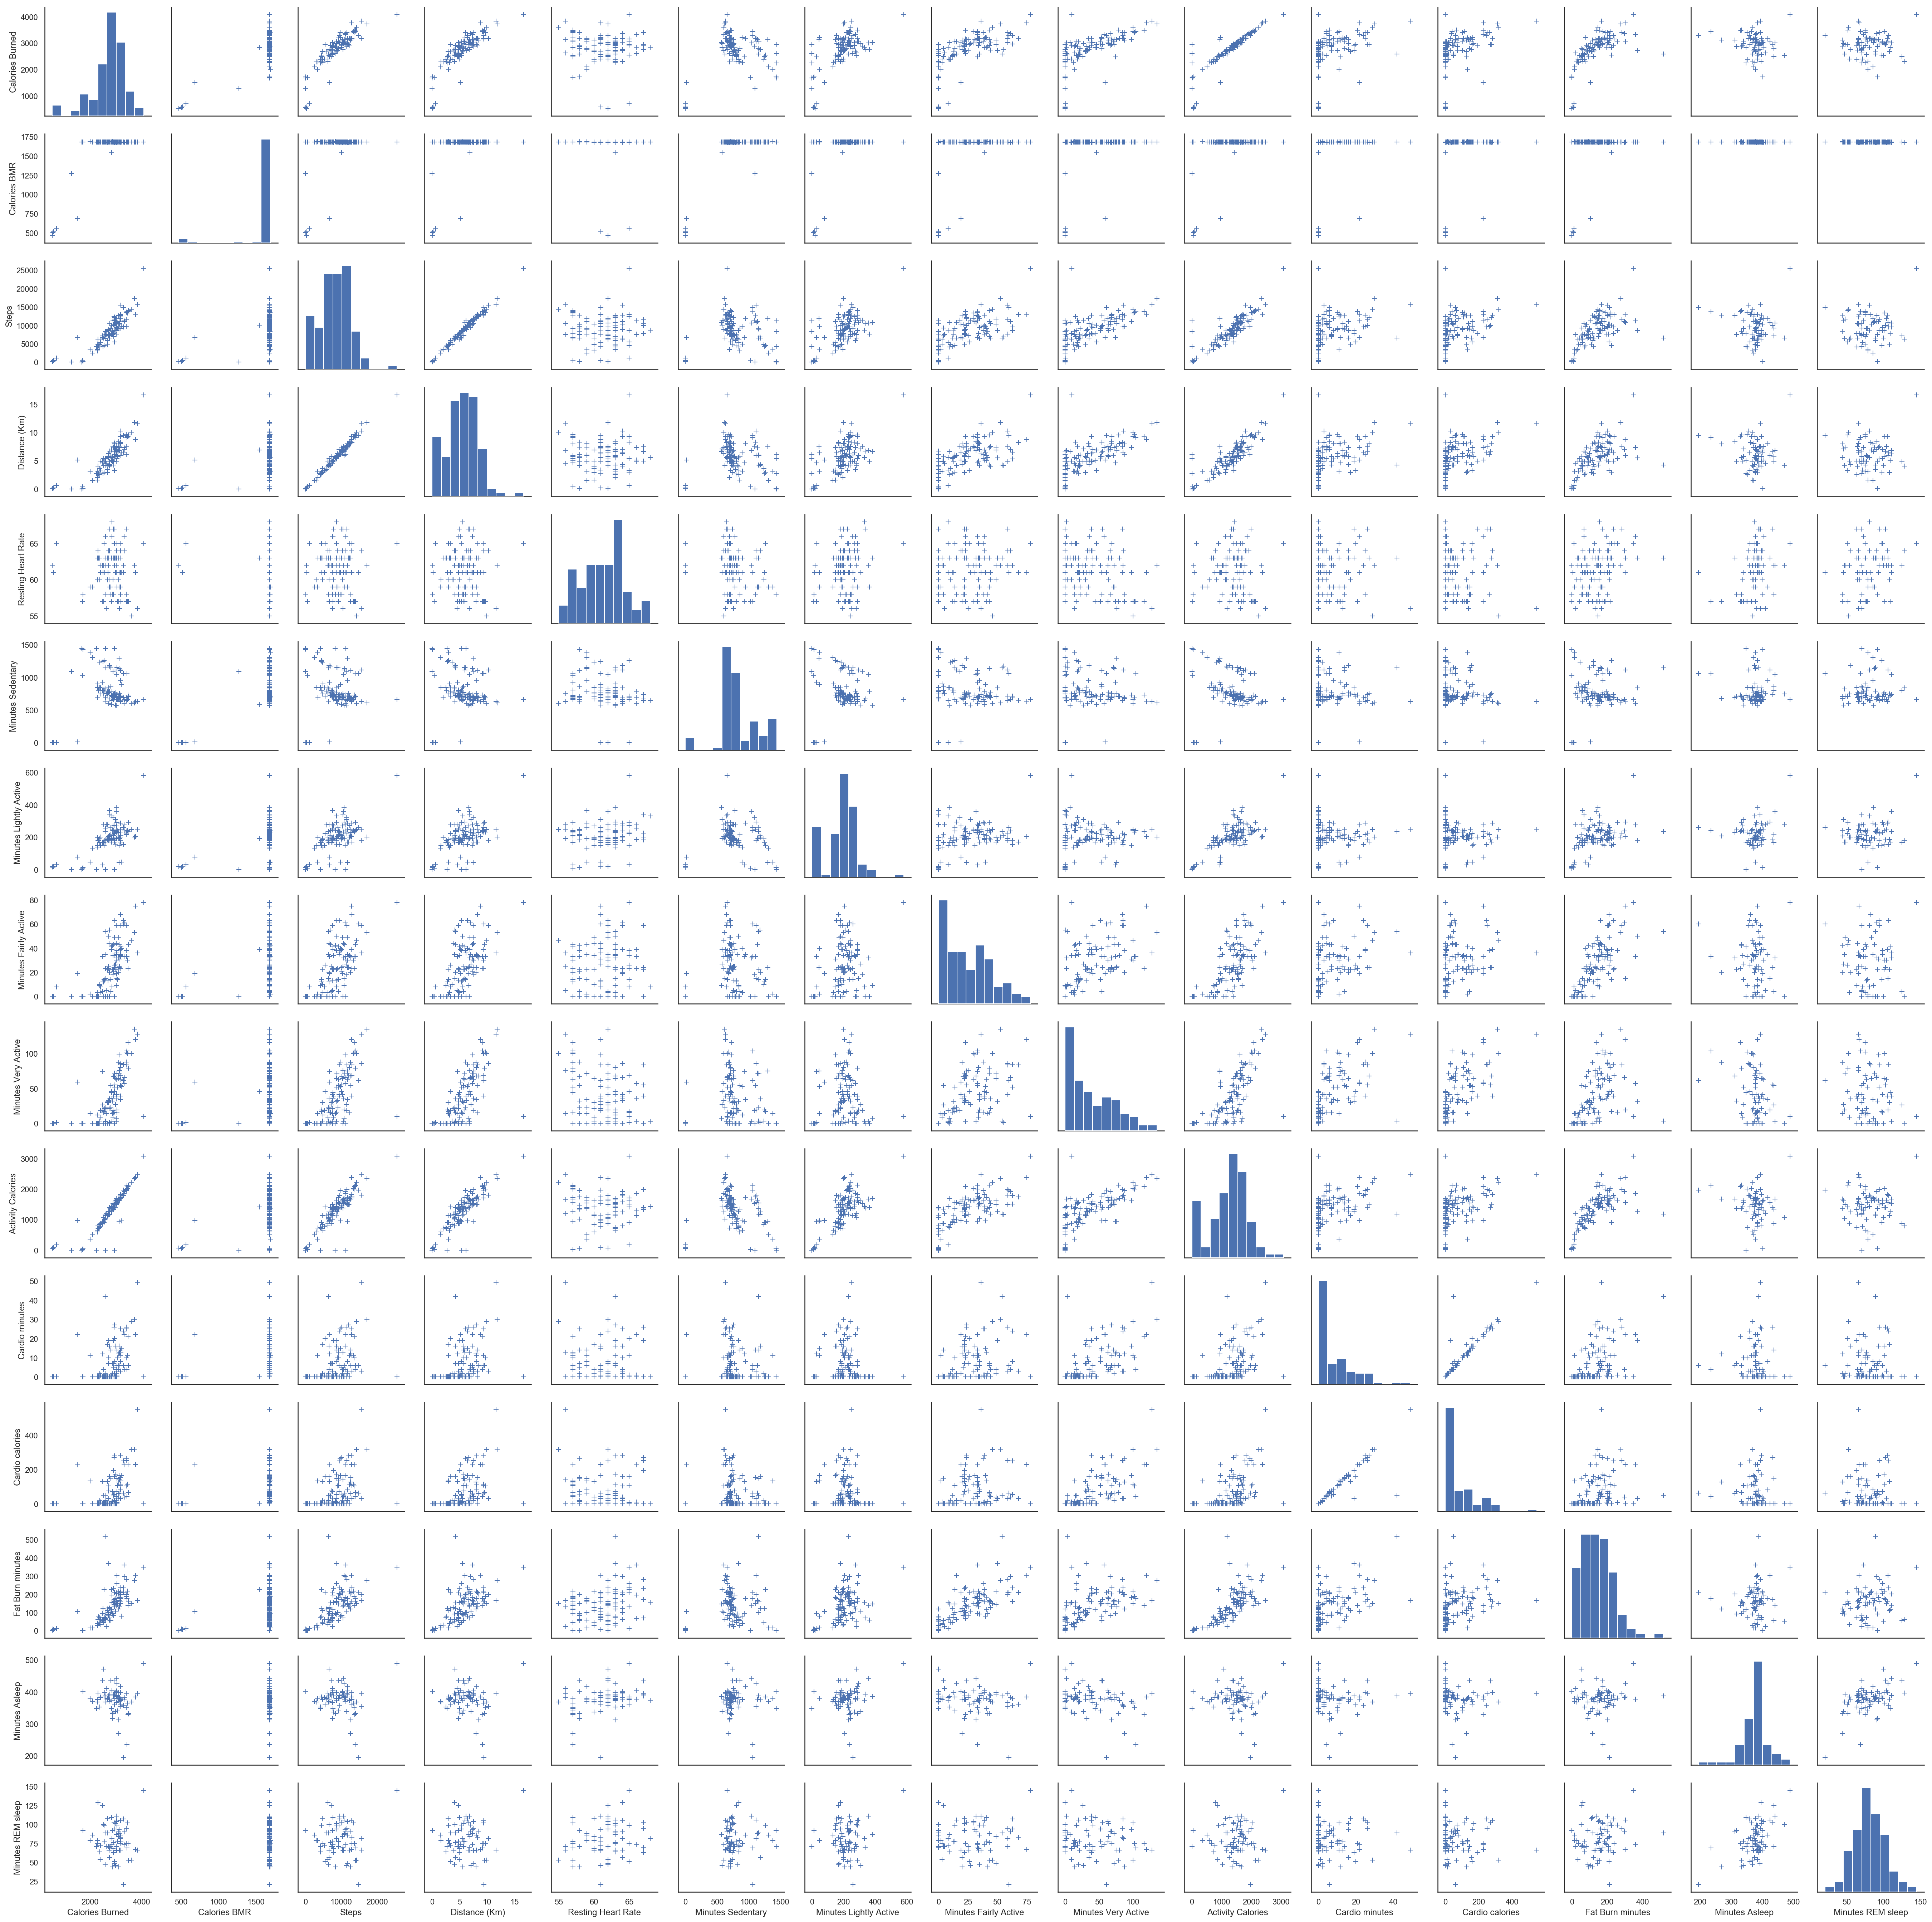

In [10]:
# Basic correlogram
sns.pairplot(data[['Calories Burned','Calories BMR','Steps','Distance (Km)',
 'Resting Heart Rate', 'Minutes Sedentary',
 'Minutes Lightly Active',
 'Minutes Fairly Active',
 'Minutes Very Active', 'Activity Calories',
 'Cardio minutes',
 'Cardio calories',
 'Fat Burn minutes','Minutes Asleep',
 'Minutes REM sleep']], kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

In [11]:
data_cut.head()


,Calories Burned,Calories BMR,Steps,Distance (Km),Resting Heart Rate,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Fat Burn minutes,Minutes Asleep,Minutes REM sleep
Date,,,,,,,,,,,,,
2018-06-24,1996,1690,3367,3.01,59.0,1377,47,2,14,362,14.0,379.0,79.0
2018-06-25,2863,1685,8394,5.55,58.0,709,244,42,14,1361,94.0,333.0,44.0
2018-06-26,3398,1683,13569,9.68,57.0,687,231,33,102,2004,187.0,351.0,75.0
2018-06-27,3442,1682,13337,9.33,57.0,665,243,30,100,2035,217.0,365.0,102.0
2018-06-28,1701,1682,559,0.36,57.0,1025,8,0,0,25,0.0,NaN,NaN


In [12]:
data_cut.shape

(116, 13)

In [13]:
data_cut.dropna(inplace=True)

/Users/justinlarocque-villiers/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
data_cut.shape

(75, 13)

In [15]:
scaled_data = StandardScaler().fit_transform(data_cut.T)

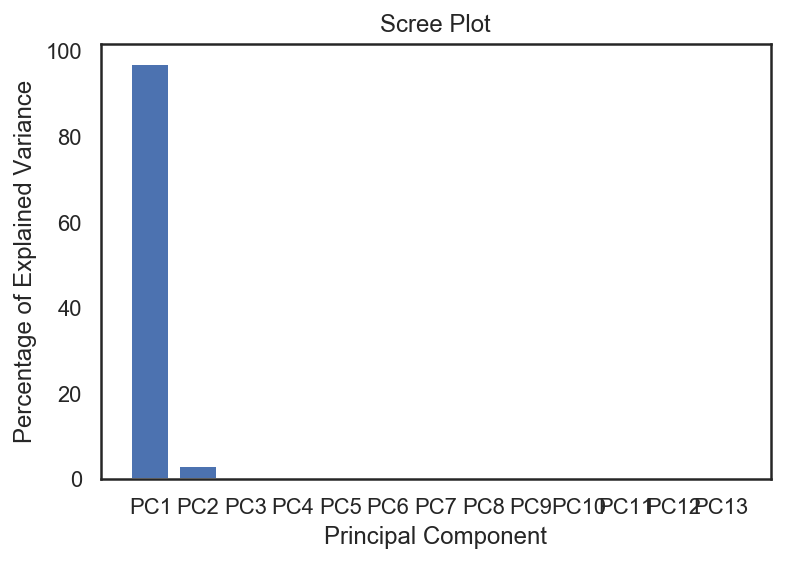

In [16]:
pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data
 
#########################
#
# Draw a scree plot and a PCA plot
#
#########################
 
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

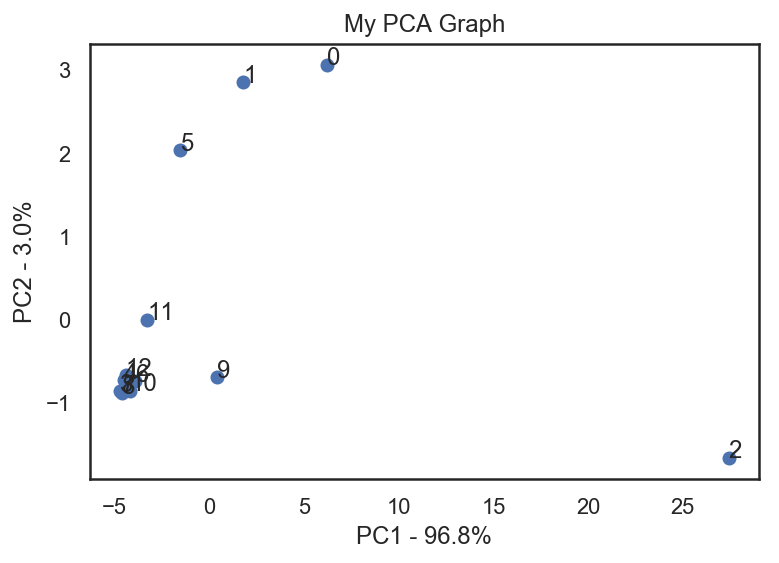

In [17]:
#the following code makes a fancy looking plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data,columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()
 

In [18]:
## get the name of the top 10 measurements (genes) that contribute
## most to pc1.
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0])
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10 = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10])

61    0.117342
1     0.117342
26    0.117320
16    0.117308
17    0.117304
53    0.117300
50    0.117298
51    0.117296
13    0.117286
60    0.117281
dtype: float64


In [19]:
mean_vec = np.mean(scaled_data, axis = 0)
cov_mat = (scaled_data - mean_vec).T.dot((scaled_data - mean_vec)) / (scaled_data.shape[0]-1)

In [20]:
cov_mat = np.cov(scaled_data.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

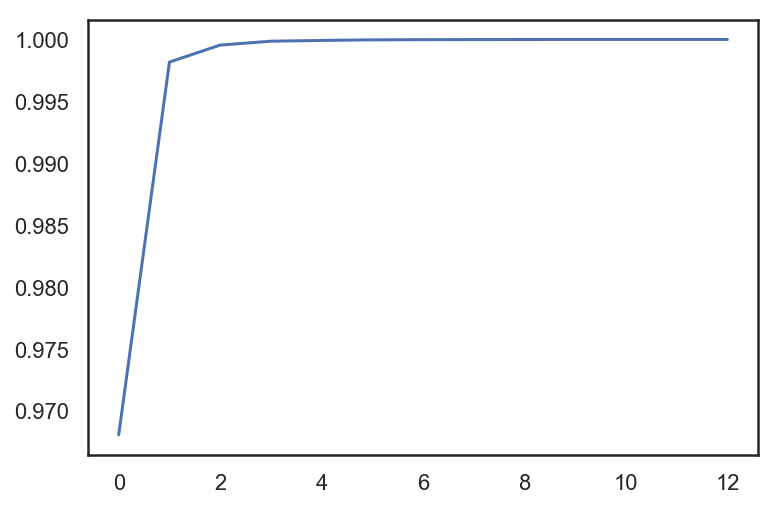

In [21]:
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [22]:
varatio = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))

In [23]:
varatio.drop([0,0], inplace=True)

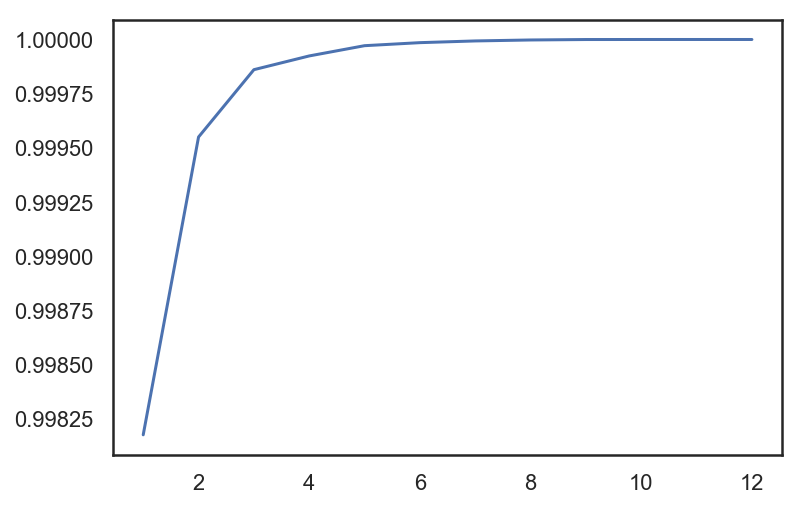

In [24]:
plt.plot(varatio)